In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Data import and basic summary
np.random.seed(49)
DashData = pd.read_csv("/Users/desktop/Desktop/All/Github/DoorDashModels/Data/historical_data.csv")
DashData.head(10)
DashData.info()
DashData.describe()
print("Percentange of missing value % :",DashData.isna().mean().mean()*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
#Creating the target variable for models
from datetime import datetime
DashData['created_at'] = pd.to_datetime(DashData['created_at'])
DashData["actual_delivery_time"] = pd.to_datetime(DashData["actual_delivery_time"])
DashData["Total_Delivery_Duration"] = (DashData["actual_delivery_time"] - DashData["created_at"]).dt.total_seconds()

DashData.head(10)
#New feature creations
DashData['Estimated_non_prep_duration'] = DashData["estimated_store_to_consumer_driving_duration"] + DashData["estimated_order_place_duration"]
DashData['BusyDriverRatio'] = DashData["total_busy_dashers"] / DashData["total_onshift_dashers"]
#Time features
DashData['Months'] = DashData['created_at'].dt.month
DashData['Quarter'] = DashData['created_at'].dt.quarter
#aggregate features
DashData['TotalOrderPerStore'] = DashData.groupby('store_id')['total_items'].transform('sum')
DashData['OrderValuePerStore'] = DashData.groupby('store_id')['total_items'].transform('mean')
DashData['OrderCountMonthsPerStore'] = DashData.groupby('Months')['total_items'].transform('sum')

#simple store metrics
avg_by_category= DashData.groupby('store_primary_category')['subtotal'].mean() / 100
print("Average subtotals per store category in dollars:")
print(avg_by_category)
std_by_category = DashData.groupby('store_primary_category')['subtotal'].std() / 100
print("\nStandard deviation of subtotals per store category in dollars:")
print(std_by_category)
print("Average order delivery time in minutes:")
print(f"{DashData['Total_Delivery_Duration'].mean()/60:.2f}")

DashData.head()



Average subtotals per store category in dollars:
store_primary_category
afghan               29.850756
african              26.997000
alcohol              26.565957
alcohol-plus-food    16.990000
american             26.585065
                       ...    
thai                 31.080275
turkish              28.858565
vegan                25.098029
vegetarian           26.007349
vietnamese           22.585660
Name: subtotal, Length: 74, dtype: float64

Standard deviation of subtotals per store category in dollars:
store_primary_category
afghan               17.588114
african              11.044908
alcohol              17.889367
alcohol-plus-food          NaN
american             16.910146
                       ...    
thai                 18.538711
turkish              16.714752
vegan                15.727010
vegetarian           15.437324
vietnamese           15.615800
Name: subtotal, Length: 74, dtype: float64
Average order delivery time in minutes:
48.47


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,Total_Delivery_Duration,Estimated_non_prep_duration,BusyDriverRatio,Months,Quarter,TotalOrderPerStore,OrderValuePerStore,OrderCountMonthsPerStore
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,446,861.0,3779.0,1307.0,0.424242,2,1,4,4.000000,411075
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,446,690.0,4024.0,1136.0,2.000000,2,1,37,2.846154,411075
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,446,690.0,1781.0,1136.0,0.000000,1,1,37,2.846154,219981
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,446,289.0,3075.0,735.0,1.000000,2,1,37,2.846154,411075
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,446,650.0,2390.0,1096.0,1.000000,2,1,37,2.846154,411075


In [6]:
#creating a dictionary for store categories to fill the null categories using the most common category -- could be better way to do with with SME
store_id_unique = DashData["store_id"].unique().tolist()
store_id_and_category = {store_id: DashData[DashData.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
DashData["nan_free_store_primary_category"] = DashData.store_id.apply(fill)


In [7]:
#creating dummies
OrderProtocalDummies =pd.get_dummies(DashData.order_protocol, dtype=int)
OrderProtocalDummies = OrderProtocalDummies.add_prefix('OrderProtocal_')
#checking
OrderProtocalDummies.head()
MarketIdDummies = pd.get_dummies(DashData.market_id, dtype=int)
MarketIdDummies = MarketIdDummies.add_prefix('MarketId_')
#checking
MarketIdDummies.head()
StoreCategoryDummies = pd.get_dummies(DashData.nan_free_store_primary_category, dtype=int)
StoreCategoryDummies = StoreCategoryDummies.add_prefix('StoreCategory_')
#checking
StoreCategoryDummies.head()

,StoreCategory_afghan,StoreCategory_african,StoreCategory_alcohol,StoreCategory_alcohol-plus-food,StoreCategory_american,StoreCategory_argentine,StoreCategory_asian,StoreCategory_barbecue,StoreCategory_belgian,StoreCategory_brazilian,...,StoreCategory_southern,StoreCategory_spanish,StoreCategory_steak,StoreCategory_sushi,StoreCategory_tapas,StoreCategory_thai,StoreCategory_turkish,StoreCategory_vegan,StoreCategory_vegetarian,StoreCategory_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# defining the intial train DF
train_df = DashData.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time","nan_free_store_primary_category", "order_protocol"])
train_df.head()
#merging the dummies to train
train_df = pd.concat([train_df, OrderProtocalDummies, MarketIdDummies, StoreCategoryDummies], axis=1)
#checking
train_df.head()
#seeing which fetures that have infinte max value -- could be issue for models
if np.isinf(train_df).any().any():
    print("Features with infinite max value:")
    print(train_df.columns[np.isinf(train_df).any()])
else:
    print("No infinite values in the dataset")
#ensuring dtype synergy
train_df = train_df.astype("Float32")

Features with infinite max value:
Index(['BusyDriverRatio'], dtype='object')


In [9]:
#replacing infinite values in BusyDriverRatio with NaN then with the mean of the column
train_df["BusyDriverRatio"] = train_df["BusyDriverRatio"].replace([np.inf, -np.inf], np.nan)
train_df["BusyDriverRatio"] = train_df["BusyDriverRatio"].fillna(train_df["BusyDriverRatio"].mean())
#checking
train_df["BusyDriverRatio"].describe()


count    197428.0
mean     0.949777
std      0.385194
min         -13.0
25%      0.846154
50%      0.949778
75%           1.0
max          31.0
Name: BusyDriverRatio, dtype: Float64

<Axes: >

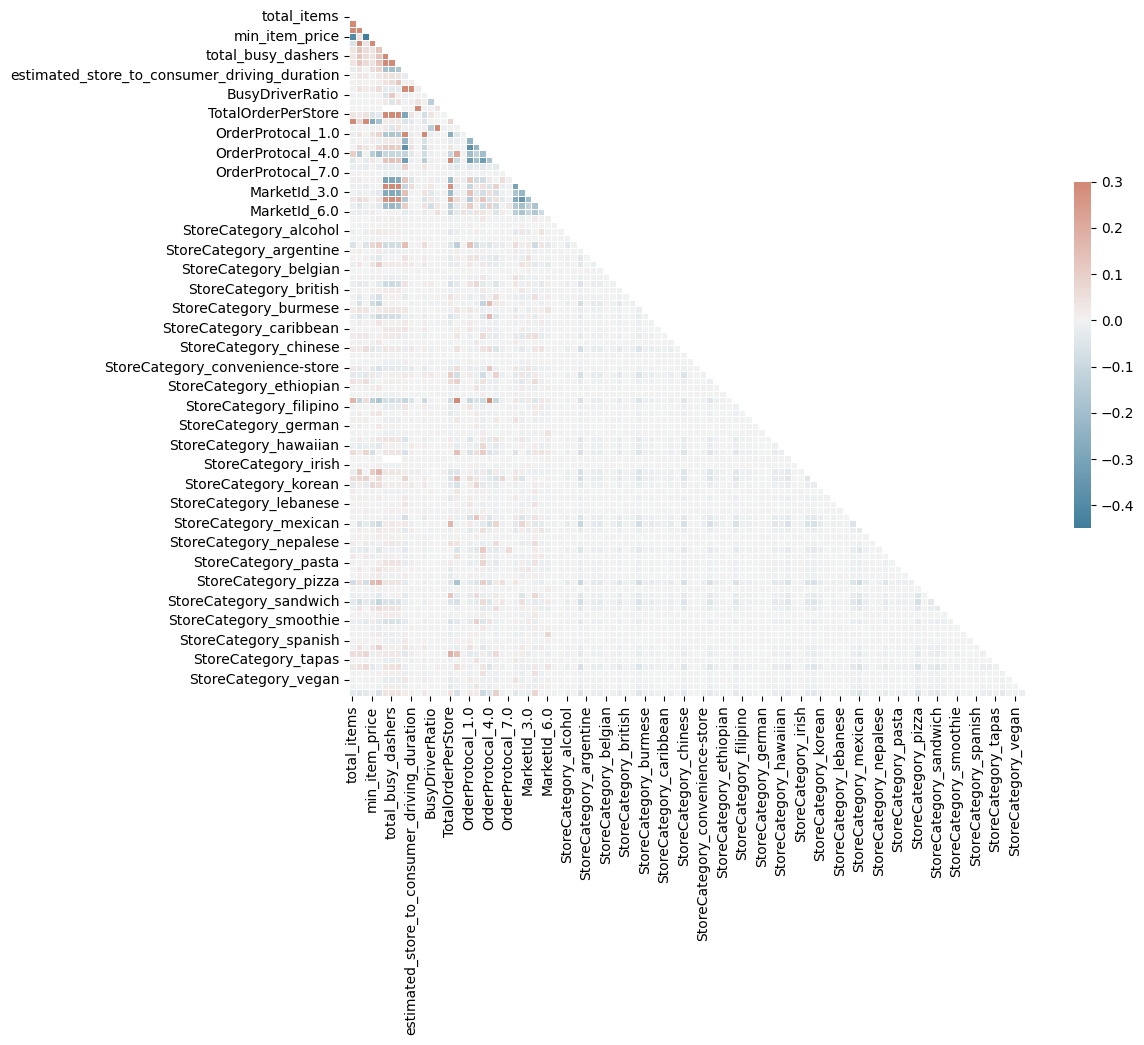

In [10]:
#Next Task (3/20): Removing Redundant and Potential Collinear Features to prepare for FAMD analysis
corrMatrix = train_df.corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [11]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sorting correlations in the descending order and return n highest results"""
    AB_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    AB_corr = AB_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return AB_corr[0:n]

print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 15))
#removing the features
train_df = DashData.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time","nan_free_store_primary_category", "order_protocol"])
train_df = pd.concat([train_df, OrderProtocalDummies, MarketIdDummies, StoreCategoryDummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers","StoreCategory_indonesian",])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)


Top Absolute Correlations

Months                                        OrderCountMonthsPerStore       0.998849
Total_Delivery_Duration                       Quarter                        0.996475
total_onshift_dashers                         total_busy_dashers             0.943789
                                              total_outstanding_orders       0.936122
total_busy_dashers                            total_outstanding_orders       0.932913
estimated_store_to_consumer_driving_duration  Estimated_non_prep_duration    0.923613
estimated_order_place_duration                OrderProtocal_1.0              0.895608
total_items                                   num_distinct_items             0.763912
subtotal                                      num_distinct_items             0.681101
total_items                                   subtotal                       0.558067
min_item_price                                max_item_price                 0.545484
subtotal                   

In [12]:
#checking the abs cor again
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 25))
#removing highly correlated features -- could be better with consulting SME for feature importance in dataset
train_df = train_df.drop(columns=["Months", "estimated_order_place_duration","Estimated_non_prep_duration",])


Top Absolute Correlations

Months                                        OrderCountMonthsPerStore       1.000000
estimated_store_to_consumer_driving_duration  Estimated_non_prep_duration    0.923086
estimated_order_place_duration                OrderProtocal_1.0              0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
OrderProtocal_4.0                             StoreCategory_fast             0.489946
num_distinct_items                            min_item_price                 0.446733
total_items                                   OrderValuePerStore             0.438134
MarketId_2.0               

In [13]:
#checking the abs cor again
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 25))

Top Absolute Correlations

total_items               num_distinct_items    0.758146
subtotal                  num_distinct_items    0.682890
total_items               subtotal              0.557175
min_item_price            max_item_price        0.541241
subtotal                  max_item_price        0.507947
OrderProtocal_4.0         StoreCategory_fast    0.489946
num_distinct_items        min_item_price        0.446733
total_items               OrderValuePerStore    0.438134
MarketId_2.0              MarketId_4.0          0.402421
OrderValuePerStore        StoreCategory_fast    0.390871
total_items               min_item_price        0.389277
OrderProtocal_1.0         OrderProtocal_3.0     0.373581
                          OrderProtocal_5.0     0.342345
TotalOrderPerStore        OrderProtocal_5.0     0.341527
num_distinct_items        OrderValuePerStore    0.340753
MarketId_1.0              MarketId_2.0          0.334580
OrderProtocal_3.0         OrderProtocal_5.0     0.332533
tota

In [14]:
# Still some features that are highly correlated --  creating some new features to replace the old ones
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["num_distinct_items", "subtotal","max_item_price", "min_item_price","OrderCountMonthsPerStore"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
OrderProtocal_4.0         StoreCategory_fast                0.489946
total_items               percent_distinct_item_of_total    0.445751
                          OrderValuePerStore                0.438134
MarketId_2.0              MarketId_4.0                      0.402421
OrderValuePerStore        StoreCategory_fast                0.390871
OrderProtocal_1.0         OrderProtocal_3.0                 0.373581
                          OrderProtocal_5.0                 0.342345
TotalOrderPerStore        OrderProtocal_5.0                 0.341527
MarketId_1.0              MarketId_2.0                      0.334580
total_items               price_range_of_items              0.333304
OrderProtocal_3.0         OrderProtocal_5.0                 0.332533
total_outstanding_orders  TotalOrderPerStore                0.323744
total_items               avg_price_per_item                0.310759
MarketId_1.0              MarketId_4.0                      0.302136
OrderVal

In [15]:
#Doing multicolinarity check using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
#function for VIF
def calculateVIF(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

#checking VIF

features = train_df.columns.to_list()
vif_data = calculateVIF(features)
vif_data



,feature,VIF
0,StoreCategory_alcohol-plus-food,1.001494
1,StoreCategory_chocolate,1.001526
2,StoreCategory_belgian,1.002844
3,StoreCategory_russian,1.014007
4,BusyDriverRatio,1.014008
...,...,...
92,OrderProtocal_3.0,51.221294
93,MarketId_4.0,51.444287
94,OrderProtocal_1.0,52.619170
95,MarketId_2.0,56.007884


In [16]:
#Wanting to drop the features with VIF > 20
features_to_drop = vif_data[vif_data["VIF"] > 20]["feature"].to_list()
features_to_drop
train_df.drop(columns=features_to_drop, inplace=True)
#checking the VIF again
features = train_df.columns.to_list()
vif_data = calculateVIF(features)
selected_features = vif_data['feature'].values.tolist()
vif_data

,feature,VIF
0,StoreCategory_alcohol-plus-food,1.000059
1,StoreCategory_belgian,1.000064
2,StoreCategory_chocolate,1.000101
3,StoreCategory_russian,1.000358
4,StoreCategory_gluten-free,1.000500
...,...,...
78,Total_Delivery_Duration,5.595255
79,BusyDriverRatio,6.038102
80,estimated_store_to_consumer_driving_duration,7.101717
81,OrderValuePerStore,12.538613


In [17]:

#checking to see if there are any infinite values
if np.isinf(train_df).any().any():
    print("Features with infinite max value:")
    print(train_df.columns[np.isinf(train_df).any()])
else:
    print("No infinite values in the dataset")

No infinite values in the dataset


Top 10 correlations with target:
estimated_store_to_consumer_driving_duration    0.188418
total_outstanding_orders                        0.157604
price_range_of_items                            0.104689
total_items                                     0.092811
avg_price_per_item                              0.062334
BusyDriverRatio                                 0.048316
StoreCategory_japanese                          0.043111
OrderProtocal_6.0                               0.034102
StoreCategory_indian                            0.023583
StoreCategory_italian                           0.020790
dtype: float64


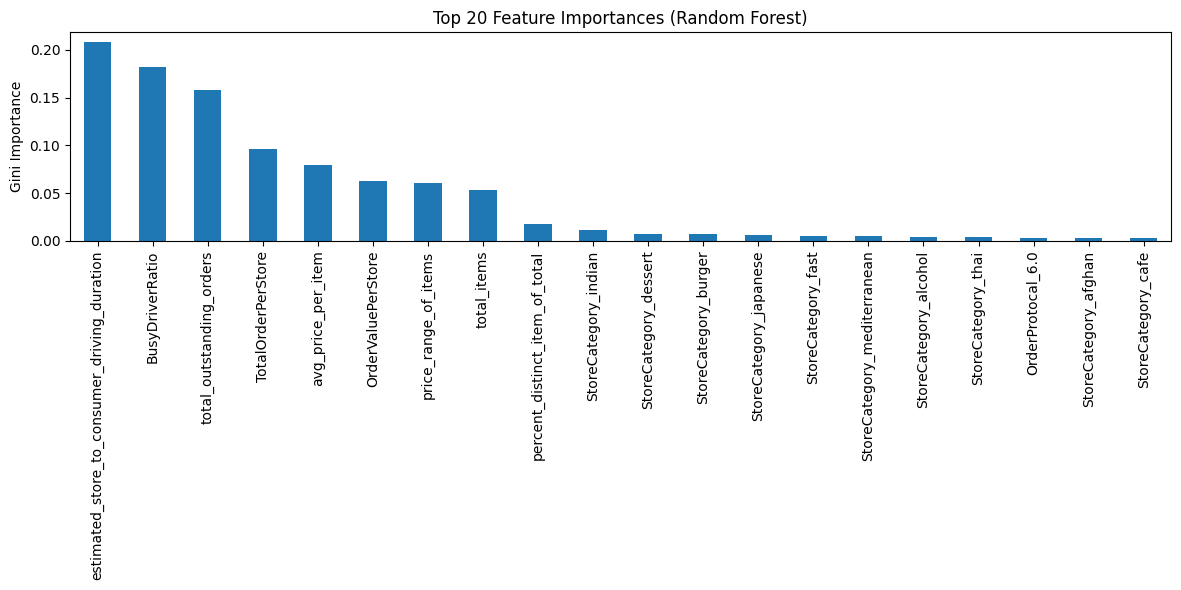

Top 20 most important features:
estimated_store_to_consumer_driving_duration    0.207966
BusyDriverRatio                                 0.182379
total_outstanding_orders                        0.158461
TotalOrderPerStore                              0.095846
avg_price_per_item                              0.079142
OrderValuePerStore                              0.062949
price_range_of_items                            0.060589
total_items                                     0.053036
percent_distinct_item_of_total                  0.017180
StoreCategory_indian                            0.011548
StoreCategory_dessert                           0.007237
StoreCategory_burger                            0.006658
StoreCategory_japanese                          0.005703
StoreCategory_fast                              0.004999
StoreCategory_mediterranean                     0.004782
StoreCategory_alcohol                           0.003896
StoreCategory_thai                              0.003503

In [19]:

X = train_df.drop(columns=["Total_Delivery_Duration"])
y = train_df["Total_Delivery_Duration"]

# Check correlations between each feature and the target
#     helps identify any "too-perfect" feature (data leakage).
numeric_cols = X.select_dtypes(include=[np.number]).columns
corr_with_target = X[numeric_cols].corrwith(y)
print("Top 10 correlations with target:")
print(corr_with_target.sort_values(ascending=False).head(10))


# Scale the features:
from sklearn.preprocessing import StandardScaler

# Train/test split:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Apply scaling after the split to avoid data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit a RandomForestRegressor:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
forest.fit(X_train_scaled, y_train)

# Check and plot feature importances:
importances = pd.Series(forest.feature_importances_, index=X.columns)
top_20 = importances.sort_values(ascending=False).head(20)
top_20.plot(kind='bar', figsize=(12,6), rot=90)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Gini Importance")
plt.tight_layout()
plt.show()

print("Top 20 most important features:")
print(top_20)


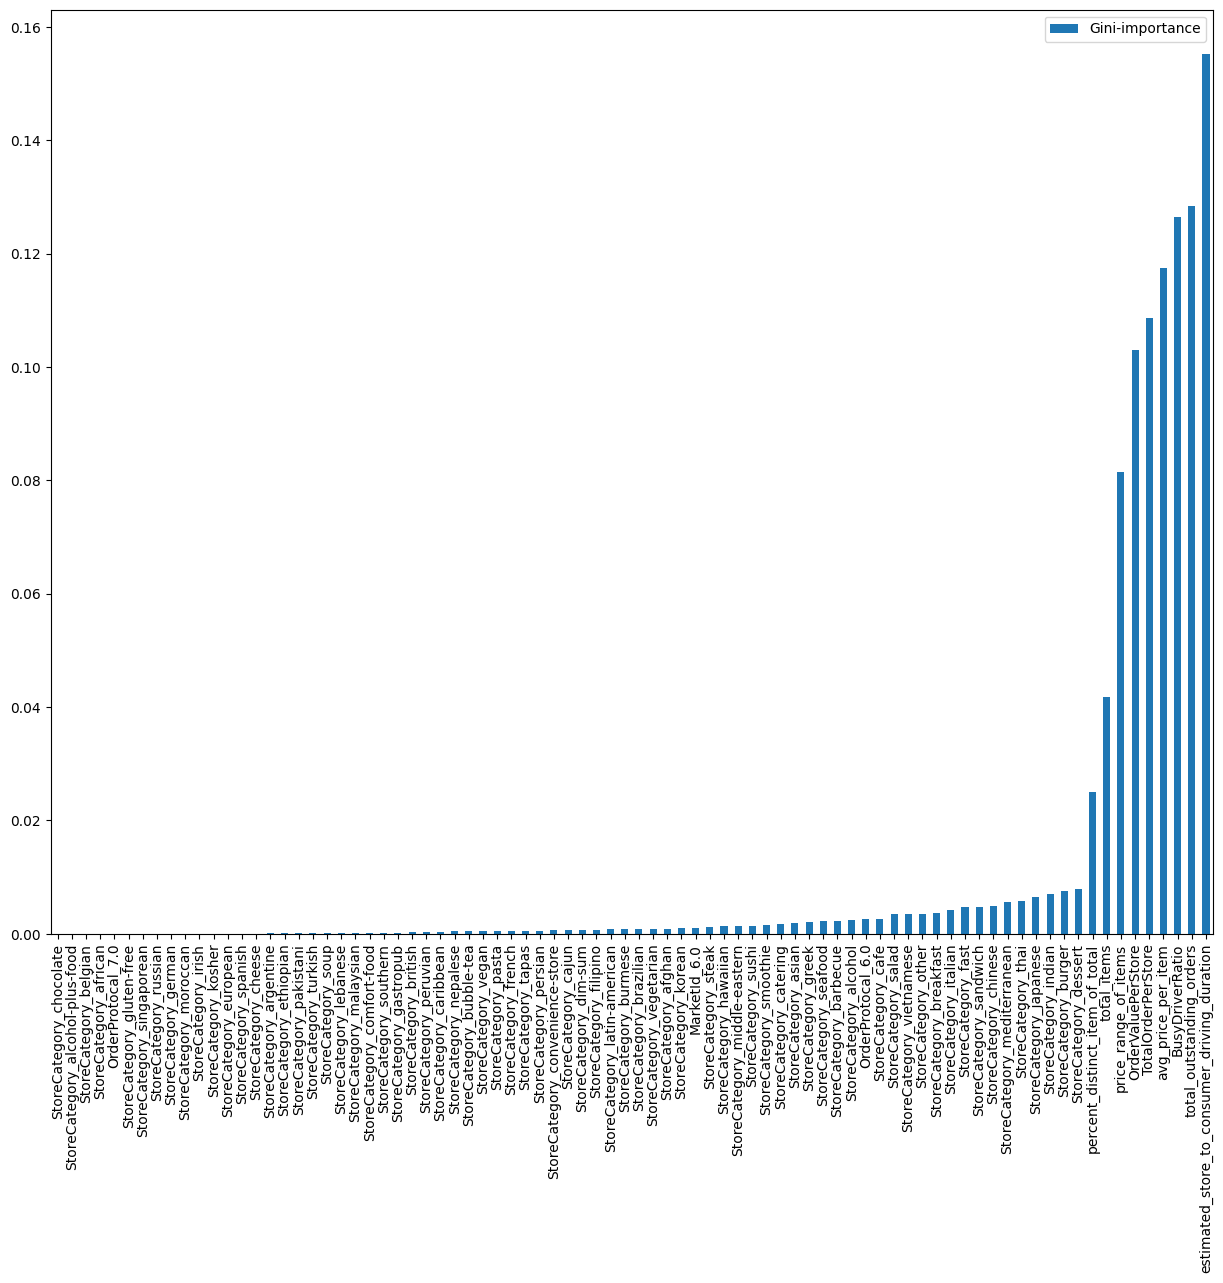

In [20]:
#plotting the feature importance
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} 
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance  

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

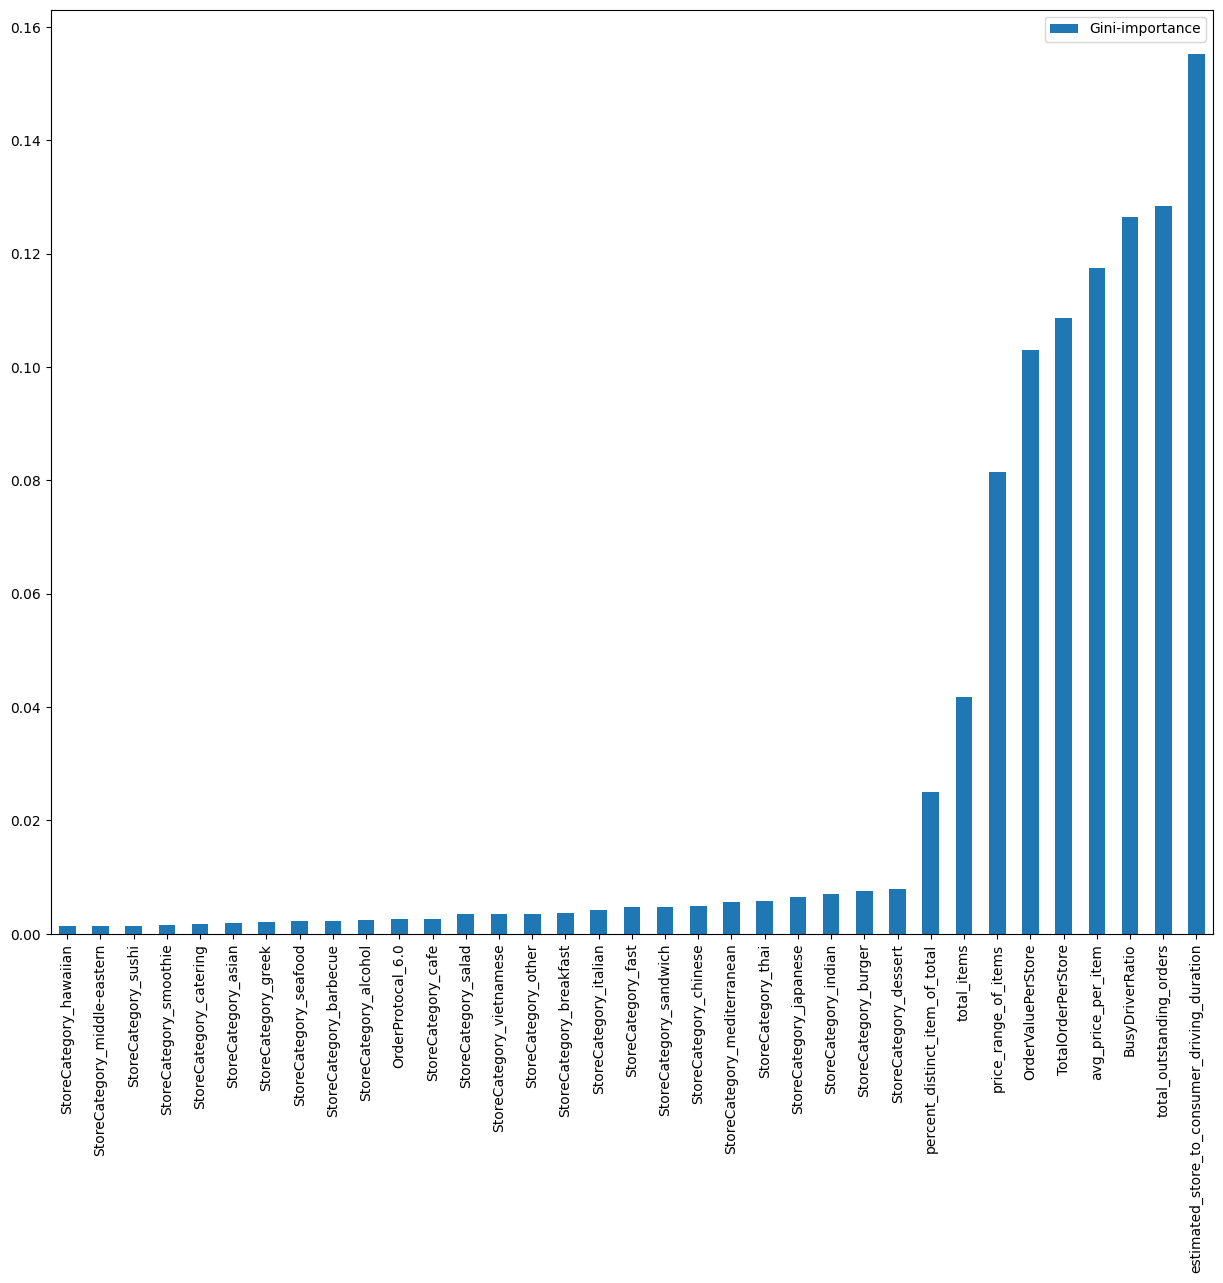

In [21]:
#checking the feature importance
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

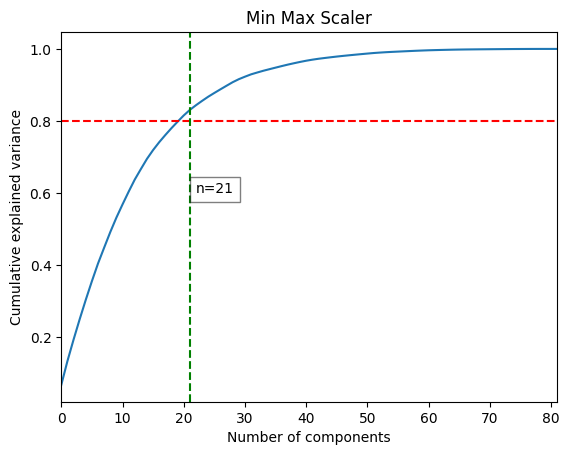

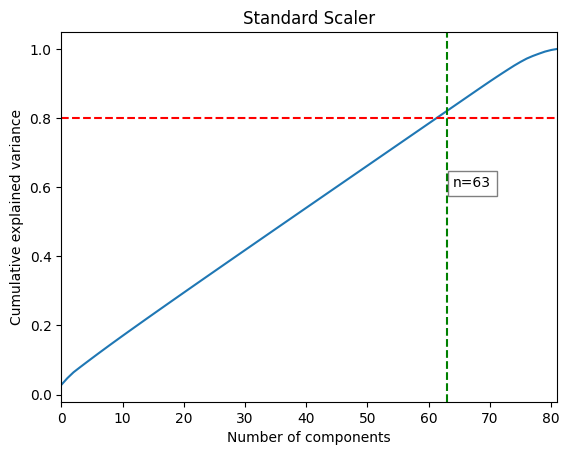

In [22]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Min Max Scaler
X_MinMaxScale=MinMaxScaler().fit_transform(X_Train)
pca = PCA().fit(X_MinMaxScale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Min Max Scaler")
plt.axhline(y=0.8, color='r', linestyle='--')
# Finding the number of components for 80% variance
n_components_80 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0] + 1
plt.axvline(x=n_components_80, color='g', linestyle='--')
plt.text(n_components_80+1, 0.6, f'n={n_components_80}', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()



# Standard Scaler
X_stdScale=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_stdScale)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title("Standard Scaler")
plt.axhline(y=0.8, color='r', linestyle='--')
n_components_80 = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.8)[0][0] + 1
plt.axvline(x=n_components_80, color='g', linestyle='--')
plt.text(n_components_80+1, 0.6, f'n={n_components_80}', 
         bbox=dict(facecolor='white', alpha=0.5))

plt.show()

##PCA shows that around 60-70 components are needed to explain ~80% of the variance in the data which makes the PCA not very useful in this case

# 3/25/25 Update: Using MinMax Scaler allowed for the PCA to be more useful in this case causing around 18-20 components to explain ~80% of the variance in the data 


In [23]:
#Inverse Transform for Metric comparison
# Since the data is scaled, need to apply the inverse transfrom to get the target variable measured in seconds and use RMSE to evaluate the errors
from sklearn.metrics import root_mean_squared_error
from math import sqrt
def my_rmse(y_true, y_pred):
    return sqrt(root_mean_squared_error(y_true, y_pred))
    


In [24]:
#scaling
def scale_features_and_target(X_train, X_test, y_train, y_test, scaler_class):
    """
    Fits the scaler on X_train and y_train only, 
    then transforms X_test and y_test with the same scaler.
    
    Returns: 
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
        X_scaler, y_scaler
    """
    # Create new instances for each scaler
    X_scaler = scaler_class()
    y_scaler = scaler_class()
    
    # Fit on training data only
    X_train_scaled = X_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    
    # Transform the test data using the same scalers
    X_test_scaled = X_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))
    
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler


def scale_features_only(X_train, X_test, y_train, y_test, scaler_class):
    """Scales only the features (X). Leaves y in its original units (e.g., seconds)."""
    X_scaler = scaler_class()
    X_train_scaled = X_scaler.fit_transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    
    return X_train_scaled, X_test_scaled, y_train, y_test, X_scaler

In [25]:
#Need the inverse transform to convert the scaled predictions back to the original units (seconds)
def RMSEInverse(y_scaler, y_test, y_pred_scaled, model_name):
    # Inverse-transform the scaled predictions
    y_pred_unscaled = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))[:,0]
    rmse_error = root_mean_squared_error(y_test, y_pred_unscaled)
    print(f"Error in original units = {rmse_error:.2f} in {model_name}")
    return rmse_error, y_pred_unscaled

In [26]:
#function to run the models:
def run_model(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply the selected model and measure train and test RMSE."""
    model.fit(X_train, y_train)
    
    # Predictions on the training set
    y_train_pred = model.predict(X_train)
    train_error = root_mean_squared_error(y_train, y_train_pred)
    
    # Predictions on the test set
    y_test_pred = model.predict(X_test)
    test_error = root_mean_squared_error(y_test, y_test_pred)
    
    if verbose:
        print("Train error = {:.2f} in {}".format(train_error, model_name))
        print("Test error = {:.2f} in {}".format(test_error, model_name))
    
    return model, y_train_pred, y_test_pred, train_error, test_error



--- Scaler: Standard scaler (Features+Target), Feature Set: *** full dataset ***

Train error = 0.93 in Ridge
Test error = 1.78 in Ridge
Error in original units = 2053.94 in Ridge
Train error = 0.90 in Decision Tree
Test error = 1.81 in Decision Tree
Error in original units = 2092.20 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.88 in Random Forest
Test error = 1.77 in Random Forest
Error in original units = 2045.68 in Random Forest
Train error = 0.72 in XGBoost
Test error = 1.76 in XGBoost
Error in original units = 2023.73 in XGBoost
Train error = 0.93 in Linear Regression
Test error = 1.78 in Linear Regression
Error in original units = 2053.94 in Linear Regression

--- Scaler: MinMax scaler (Features+Target), Feature Set: *** full dataset ***

Train error = 0.02 in Ridge
Test error = 0.04 in Ridge
Error in original units = 2054.34 in Ridge
Train error = 0.02 in Decision Tree
Test error = 0.04 in Decision Tree
Error in original units = 2075.04 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.02 in Random Forest
Test error = 0.04 in Random Forest
Error in original units = 2045.65 in Random Forest
Train error = 0.01 in XGBoost
Test error = 0.04 in XGBoost
Error in original units = 2021.52 in XGBoost
Train error = 0.02 in Linear Regression
Test error = 0.04 in Linear Regression
Error in original units = 2053.94 in Linear Regression

--- Scaler: Standard scaler (Features Only), Feature Set: *** full dataset ***

Train error = 1076.26 in Ridge
Test error = 2053.94 in Ridge
Train error = 1038.65 in Decision Tree
Test error = 2068.02 in Decision Tree
Train error = 1014.20 in Random Forest
Test error = 2045.68 in Random Forest
Train error = 830.13 in XGBoost
Test error = 2023.73 in XGBoost
Train error = 1076.26 in Linear Regression
Test error = 2053.94 in Linear Regression

--- Scaler: MinMax scaler (Features Only), Feature Set: *** full dataset ***

Train error = 1076.47 in Ridge
Test error = 2054.34 in Ridge
Train error = 1038.65 in Decision Tree
Test error = 209

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.77652e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1038.65 in Decision Tree
Test error = 2092.14 in Decision Tree
Train error = 1014.19 in Random Forest
Test error = 2045.65 in Random Forest
Train error = 830.13 in XGBoost
Test error = 2023.73 in XGBoost
Train error = 1076.26 in Linear Regression
Test error = 2053.93 in Linear Regression

--- Scaler: Standard scaler (Features+Target), Feature Set: *** selected_features_40 ***

Train error = 0.94 in Ridge
Test error = 1.79 in Ridge
Error in original units = 2059.92 in Ridge
Train error = 0.91 in Decision Tree
Test error = 1.79 in Decision Tree
Error in original units = 2060.02 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.89 in Random Forest
Test error = 1.78 in Random Forest
Error in original units = 2047.03 in Random Forest
Train error = 0.73 in XGBoost
Test error = 1.76 in XGBoost
Error in original units = 2027.76 in XGBoost
Plotting the tree for this feature set and scaler type:selected_features_40 and Standard scaler (Features+Target)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


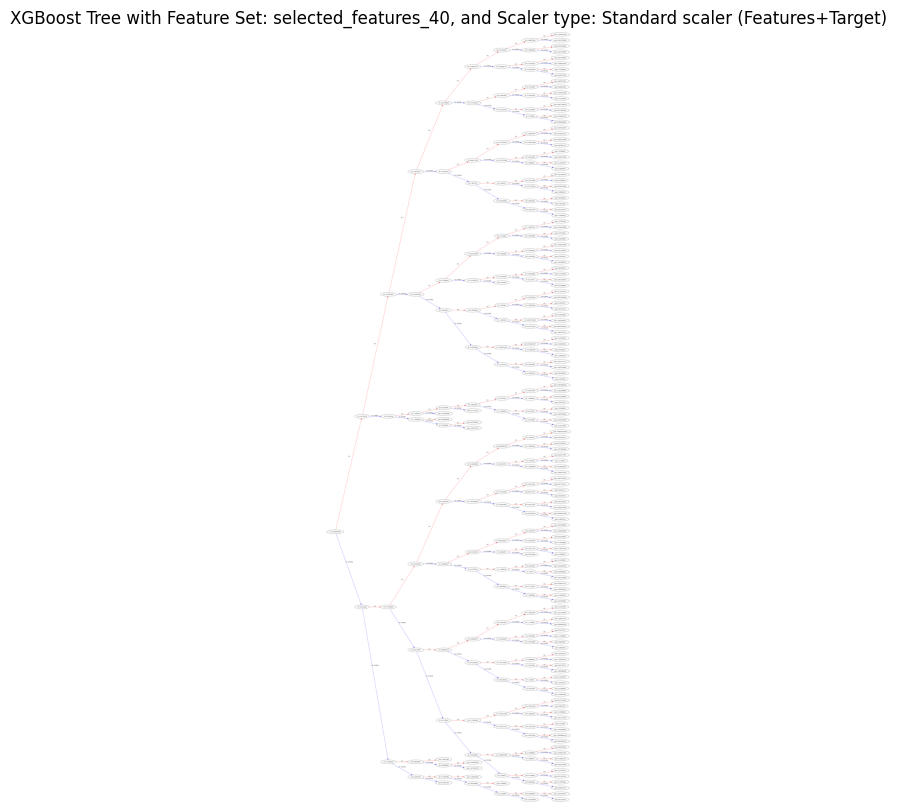

Train error = 0.94 in Linear Regression
Test error = 1.79 in Linear Regression
Error in original units = 2059.92 in Linear Regression

--- Scaler: MinMax scaler (Features+Target), Feature Set: *** selected_features_40 ***

Train error = 0.02 in Ridge
Test error = 0.04 in Ridge
Error in original units = 2060.31 in Ridge
Train error = 0.02 in Decision Tree
Test error = 0.04 in Decision Tree
Error in original units = 2076.80 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.02 in Random Forest
Test error = 0.04 in Random Forest
Error in original units = 2046.97 in Random Forest
Train error = 0.01 in XGBoost
Test error = 0.04 in XGBoost
Error in original units = 2027.35 in XGBoost
Plotting the tree for this feature set and scaler type:selected_features_40 and MinMax scaler (Features+Target)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


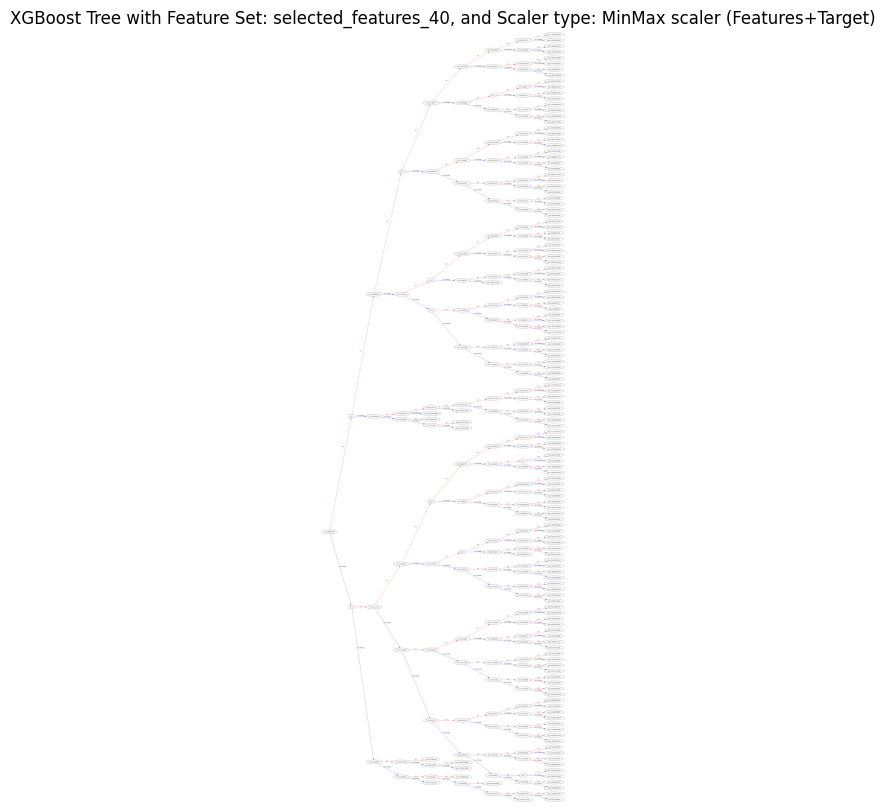

Train error = 0.02 in Linear Regression
Test error = 0.04 in Linear Regression
Error in original units = 2059.92 in Linear Regression

--- Scaler: Standard scaler (Features Only), Feature Set: *** selected_features_40 ***

Train error = 1086.32 in Ridge
Test error = 2059.92 in Ridge
Train error = 1046.75 in Decision Tree
Test error = 2085.94 in Decision Tree
Train error = 1024.84 in Random Forest
Test error = 2047.03 in Random Forest
Train error = 837.02 in XGBoost
Test error = 2027.76 in XGBoost
Plotting the tree for this feature set and scaler type:selected_features_40 and Standard scaler (Features Only)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


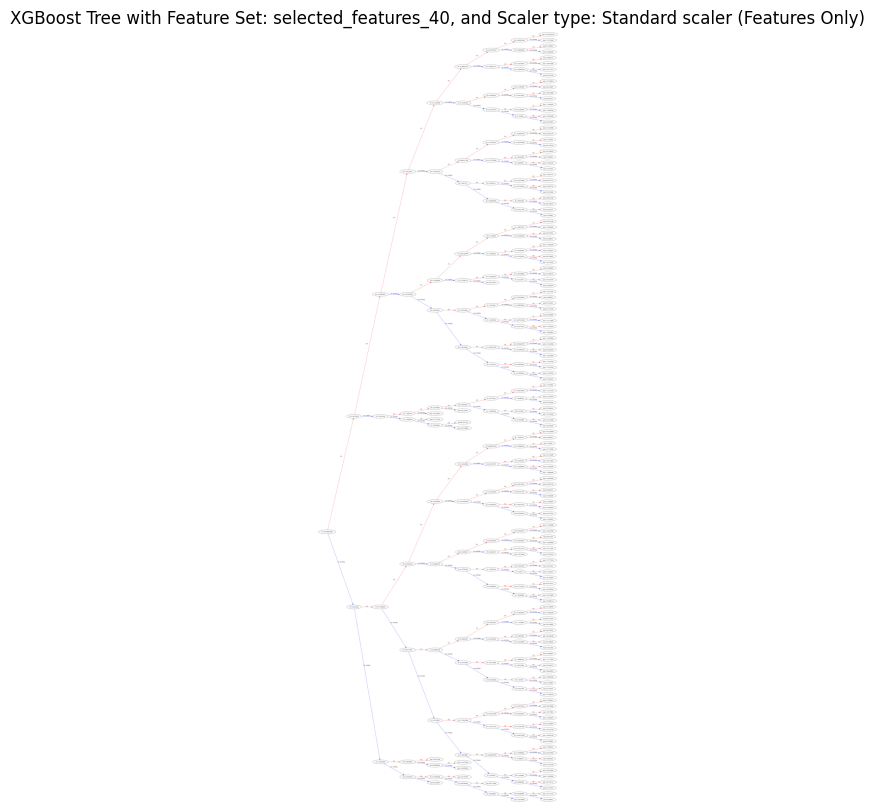

Train error = 1086.32 in Linear Regression
Test error = 2059.92 in Linear Regression

--- Scaler: MinMax scaler (Features Only), Feature Set: *** selected_features_40 ***

Train error = 1086.51 in Ridge
Test error = 2060.31 in Ridge
Train error = 1046.75 in Decision Tree
Test error = 2061.60 in Decision Tree
Train error = 1024.85 in Random Forest
Test error = 2046.97 in Random Forest
Train error = 837.02 in XGBoost
Test error = 2027.76 in XGBoost
Plotting the tree for this feature set and scaler type:selected_features_40 and MinMax scaler (Features Only)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


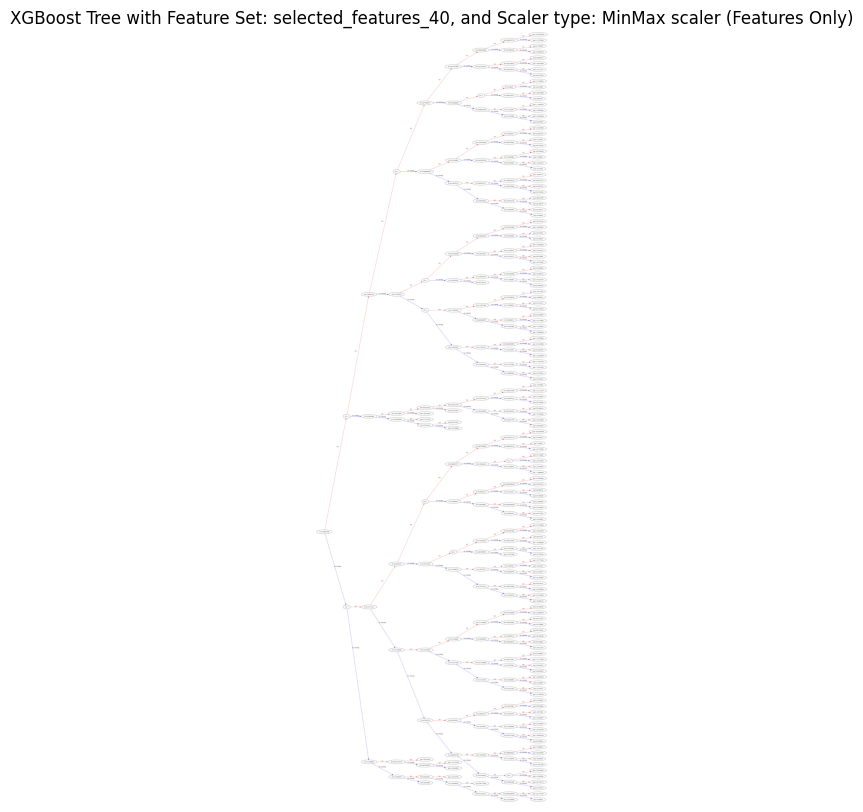

Train error = 1086.32 in Linear Regression
Test error = 2059.92 in Linear Regression

--- Scaler: Not Scaled, Feature Set: *** selected_features_40 ***

Train error = 1086.32 in Ridge
Test error = 2059.92 in Ridge


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.09963e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1046.75 in Decision Tree
Test error = 2085.86 in Decision Tree
Train error = 1024.84 in Random Forest
Test error = 2046.97 in Random Forest
Train error = 837.02 in XGBoost
Test error = 2027.76 in XGBoost
Plotting the tree for this feature set and scaler type:selected_features_40 and Not Scaled


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


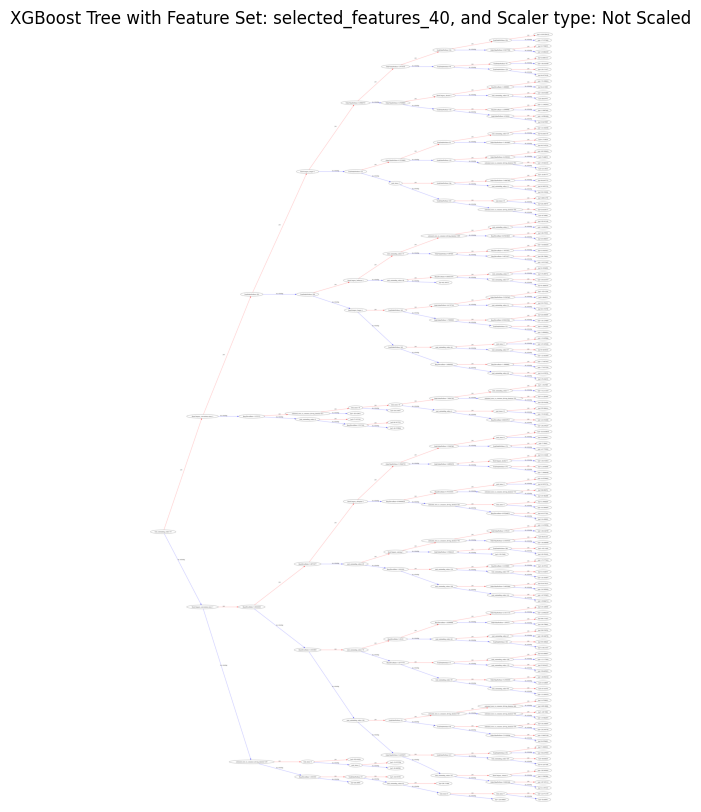

Train error = 1086.32 in Linear Regression
Test error = 2059.92 in Linear Regression

--- Scaler: Standard scaler (Features+Target), Feature Set: *** selected_features_20 ***

Train error = 0.94 in Ridge
Test error = 1.79 in Ridge
Error in original units = 2060.37 in Ridge
Train error = 0.91 in Decision Tree
Test error = 1.79 in Decision Tree
Error in original units = 2062.38 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.89 in Random Forest
Test error = 1.78 in Random Forest
Error in original units = 2047.50 in Random Forest
Train error = 0.73 in XGBoost
Test error = 1.76 in XGBoost
Error in original units = 2027.67 in XGBoost
Train error = 0.94 in Linear Regression
Test error = 1.79 in Linear Regression
Error in original units = 2060.37 in Linear Regression

--- Scaler: MinMax scaler (Features+Target), Feature Set: *** selected_features_20 ***

Train error = 0.02 in Ridge
Test error = 0.04 in Ridge
Error in original units = 2060.76 in Ridge
Train error = 0.02 in Decision Tree
Test error = 0.04 in Decision Tree
Error in original units = 2088.20 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.02 in Random Forest
Test error = 0.04 in Random Forest
Error in original units = 2047.40 in Random Forest
Train error = 0.01 in XGBoost
Test error = 0.04 in XGBoost
Error in original units = 2028.09 in XGBoost
Train error = 0.02 in Linear Regression
Test error = 0.04 in Linear Regression
Error in original units = 2060.37 in Linear Regression

--- Scaler: Standard scaler (Features Only), Feature Set: *** selected_features_20 ***

Train error = 1087.53 in Ridge
Test error = 2060.37 in Ridge
Train error = 1045.53 in Decision Tree
Test error = 2088.15 in Decision Tree
Train error = 1027.04 in Random Forest
Test error = 2047.50 in Random Forest
Train error = 836.92 in XGBoost
Test error = 2027.67 in XGBoost
Train error = 1087.53 in Linear Regression
Test error = 2060.37 in Linear Regression

--- Scaler: MinMax scaler (Features Only), Feature Set: *** selected_features_20 ***

Train error = 1087.72 in Ridge
Test error = 2060.76 in Ridge
Train error = 1045.53 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.1016e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1045.53 in Decision Tree
Test error = 2079.06 in Decision Tree
Train error = 1027.04 in Random Forest
Test error = 2047.40 in Random Forest
Train error = 836.92 in XGBoost
Test error = 2027.67 in XGBoost
Train error = 1087.53 in Linear Regression
Test error = 2060.37 in Linear Regression

--- Scaler: Standard scaler (Features+Target), Feature Set: *** selected_features_10 ***

Train error = 0.94 in Ridge
Test error = 1.79 in Ridge
Error in original units = 2061.04 in Ridge
Train error = 0.91 in Decision Tree
Test error = 1.79 in Decision Tree
Error in original units = 2062.31 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.89 in Random Forest
Test error = 1.78 in Random Forest
Error in original units = 2047.46 in Random Forest
Train error = 0.72 in XGBoost
Test error = 1.76 in XGBoost
Error in original units = 2025.60 in XGBoost
Train error = 0.94 in Linear Regression
Test error = 1.79 in Linear Regression
Error in original units = 2061.04 in Linear Regression

--- Scaler: MinMax scaler (Features+Target), Feature Set: *** selected_features_10 ***

Train error = 0.02 in Ridge
Test error = 0.04 in Ridge
Error in original units = 2061.43 in Ridge
Train error = 0.02 in Decision Tree
Test error = 0.04 in Decision Tree
Error in original units = 2062.34 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train error = 0.02 in Random Forest
Test error = 0.04 in Random Forest
Error in original units = 2047.45 in Random Forest
Train error = 0.01 in XGBoost
Test error = 0.04 in XGBoost
Error in original units = 2025.14 in XGBoost
Train error = 0.02 in Linear Regression
Test error = 0.04 in Linear Regression
Error in original units = 2061.04 in Linear Regression

--- Scaler: Standard scaler (Features Only), Feature Set: *** selected_features_10 ***

Train error = 1088.31 in Ridge
Test error = 2061.04 in Ridge
Train error = 1045.44 in Decision Tree
Test error = 2062.36 in Decision Tree
Train error = 1027.10 in Random Forest
Test error = 2047.46 in Random Forest
Train error = 830.51 in XGBoost
Test error = 2025.60 in XGBoost
Train error = 1088.31 in Linear Regression
Test error = 2061.04 in Linear Regression

--- Scaler: MinMax scaler (Features Only), Feature Set: *** selected_features_10 ***

Train error = 1088.50 in Ridge
Test error = 2061.43 in Ridge
Train error = 1045.44 in Decision Tree


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.58856e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Train error = 1045.44 in Decision Tree
Test error = 2062.34 in Decision Tree
Train error = 1027.11 in Random Forest
Test error = 2047.45 in Random Forest
Train error = 830.51 in XGBoost
Test error = 2025.60 in XGBoost
Train error = 1088.31 in Linear Regression
Test error = 2061.04 in Linear Regression


In [44]:
#Defining the models
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree, linear_model
from xgboost import XGBRegressor, plot_tree
from sklearn.linear_model import LinearRegression 

regression_models = {
    "Ridge": linear_model.Ridge(),
    "Decision Tree": tree.DecisionTreeRegressor(max_depth=8),
    "Random Forest": RandomForestRegressor(max_depth=8, random_state=42),
    "XGBoost": XGBRegressor(max_depth=8, random_state=42),
    "Linear Regression": linear_model.LinearRegression(),
}

# feature sets to test
feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": X.columns[:40].to_list(),
    "selected_features_20": X.columns[:20].to_list(),
    "selected_features_10": X.columns[:10].to_list(),
    
}

scalers = {
    #did scaling on target and features to see if it would help with the model performance -- need to consult SME to see if this is a good idea or just leave target in OG units.
    "Standard scaler (Features+Target)": StandardScaler,  # We'll scale both X and y
    "MinMax scaler (Features+Target)": MinMaxScaler,
    "Standard scaler (Features Only)": "Standard_Features_Only",
    "MinMax scaler (Features Only)": "MinMax_Features_Only",
    "Not Scaled": "No_Scaler",
}


pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "test_RMSE_scaled": [],
    "test_RMSE_unscaled": [],
}

for feature_set_name, feature_list in feature_sets.items():
    X_subset = X[feature_list]  # columns to use
    
    for scaler_name, scaler_class in scalers.items():
        print(f"\n--- Scaler: {scaler_name}, Feature Set: *** {feature_set_name} ***\n")
        
        # 1) Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_subset, y, test_size=0.2, random_state=42
        )
        
        # Scaling for each model
        if scaler_class == "No_Scaler":
            # No scaling of features or target
            X_train_scaled, X_test_scaled = X_train, X_test
            y_train_scaled, y_test_scaled = y_train, y_test
            X_scaler, y_scaler = None, None
            
        elif scaler_class == "Standard_Features_Only":
            # Scale only features, not target
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler = (
                scale_features_only(X_train, X_test, y_train, y_test, StandardScaler)
            )
            y_scaler = None
            
        elif scaler_class == "MinMax_Features_Only":
            # Scale only features, not target
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler = (
                scale_features_only(X_train, X_test, y_train, y_test, MinMaxScaler)
            )
            y_scaler = None
            
        else:
            # Scale both features and target
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, X_scaler, y_scaler = (
                scale_features_and_target(X_train, X_test, y_train, y_test, scaler_class)
            )
        
        # Running each model
        for model_name, model_obj in regression_models.items():
            model, _, y_test_pred_scaled, train_err, test_err = run_model(
                X_train_scaled, 
                y_train_scaled, 
                X_test_scaled, 
                y_test_scaled, 
                model_obj, 
                model_name, 
                verbose=True
            )
            
            # test_err is in "scaled" units if we scaled y
            scaled_rmse = test_err
            
            # If we actually scaled y, we can invert predictions to get an unscaled RMSE for interpretability
            if y_scaler is not None:
                # Re-run prediction for final test
                y_pred_scaled = model.predict(X_test_scaled)
                unscaled_rmse, _ = RMSEInverse(y_scaler, y_test, y_pred_scaled, model_name)
            else:
                # If y is unscaled, test_err is already in original units be default
                unscaled_rmse = scaled_rmse

            if model_name == "XGBoost" and feature_set_name == "selected_features_40":
                print(f"Plotting the tree for this feature set and scaler type:{feature_set_name} and {scaler_name}")
                plt.figure(figsize=(20,10))
                plot_tree(model, num_trees=30, rankdir='LR', ax=plt.gca())
                plt.title(f"XGBoost Tree with Feature Set: {feature_set_name}, and Scaler type: {scaler_name}")
                plt.show()

            
            # Storing results
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["test_RMSE_scaled"].append(scaled_rmse)
            pred_dict["test_RMSE_unscaled"].append(unscaled_rmse)


In [45]:
#dataframe for results
pred_df = pd.DataFrame(pred_dict)
print("\n----- Results of Predictions -----\n")
pred_df


----- Results of Predictions -----



,regression_model,feature_set,scaler_name,test_RMSE_scaled,test_RMSE_unscaled
0,Ridge,full dataset,Standard scaler (Features+Target),1.781461,2053.936279
1,Decision Tree,full dataset,Standard scaler (Features+Target),1.814652,2092.204953
2,Random Forest,full dataset,Standard scaler (Features+Target),1.774296,2045.676271
3,XGBoost,full dataset,Standard scaler (Features+Target),1.755263,2023.731689
4,Linear Regression,full dataset,Standard scaler (Features+Target),1.781460,2053.936279
...,...,...,...,...,...
95,Ridge,selected_features_10,Not Scaled,2061.040039,2061.040039
96,Decision Tree,selected_features_10,Not Scaled,2062.338922,2062.338922
97,Random Forest,selected_features_10,Not Scaled,2047.450486,2047.450486
98,XGBoost,selected_features_10,Not Scaled,2025.600952,2025.600952


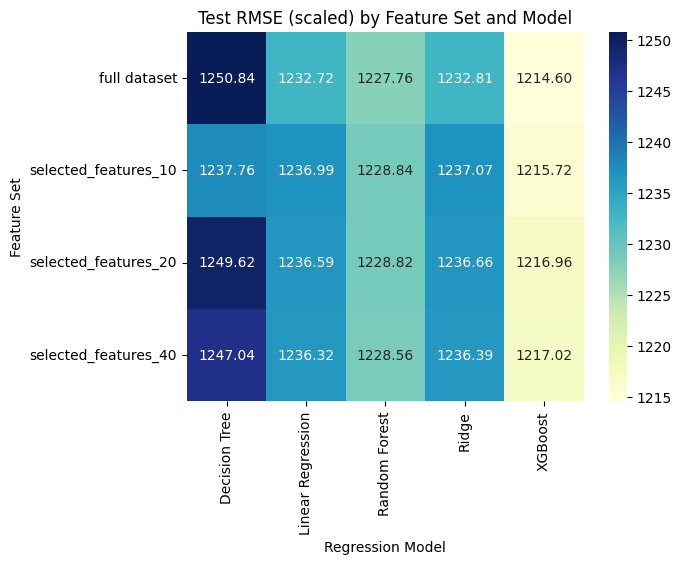

In [46]:
#plotting the pred_df
sns.heatmap(pred_df.pivot_table(index='feature_set', columns='regression_model', values='test_RMSE_scaled'), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Test RMSE (scaled) by Feature Set and Model")
plt.xlabel("Regression Model")
plt.ylabel("Feature Set")
plt.show()